# 算式识别（挑战项目）

## 描述

使用深度学习识别一张图片中的算式。

* 输入：一张彩色图片
* 输出：算式的内容

## 数据

数据集下载链接：

[https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd009/MLND+Capstone/Mathematical_Expression_Recognition_train.zip](https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd009/MLND+Capstone/Mathematical_Expression_Recognition_train.zip)

此数据集包含10万张图片，每张图里面都有一个算式。

* 可能包含 `+-*` 三种运算符
* 可能包含一对括号，也可能不包含括号
* 每个字符都可能旋转，所以 `+` 号可能长得像我们平时手写的 `*` 号，不过 `*` 号有六个瓣


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import sys
import numpy as np
import os
import datetime
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.recurrent import GRU
from keras.preprocessing import image
import keras.callbacks
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


### 查看数据集的情况，包含图片路径和内容标签

In [2]:
csv_path = 'train.csv'
df = pd.read_csv(csv_path)
df.head(5)

filename      label
0  train/0.jpg  (0+0)+9=9
1  train/1.jpg   9*8+6=78
2  train/2.jpg    1+7+0=8
3  train/3.jpg   5+4+9=18
4  train/4.jpg  7-(1*7)=0

### 显示图片和旋转图片的效果

(5, 300, 64, 3)


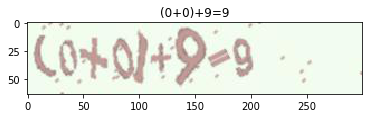

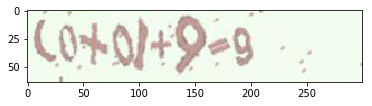

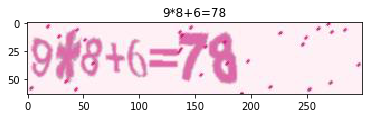

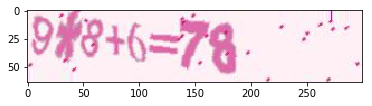

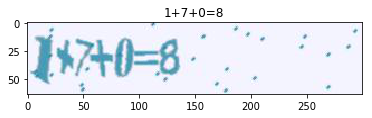

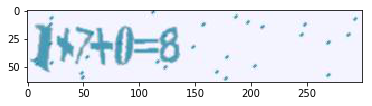

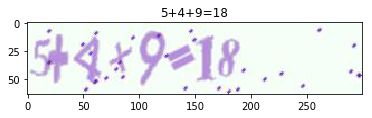

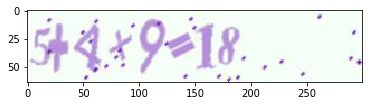

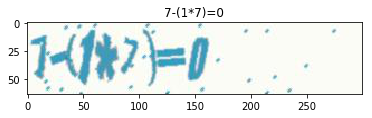

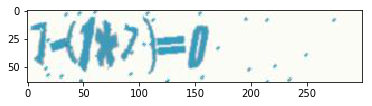

In [3]:
def show_imgs(imgs, labels):       
    for i in range(len(imgs)): 
        plt.title(labels[i])
        img = imgs[i].transpose(1, 0, 2)
        plt.imshow(img)
        plt.show()
        h, w, _ = img.shape
        img = image.random_rotation(img,
                                    3 * (w - h//5) / w + 1,
                                    row_axis=0,
                                    col_axis=1,
                                    channel_axis=2,)
        plt.imshow(img)
        plt.show()
        
def load_imgs(series):
    total = len(series)
    imgs = np.empty((len(series), width, height, depth),dtype=np.uint8)
    for i,img_path in enumerate(series):     
        if ((i+1) % 100) == 0:
            print("\rImg Processing: {:,}/{:,}".format(i+1, total), end="")
            sys.stdout.flush()
        bgr_img = cv2.imread(img_path)
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        imgs[i] = rgb_img.transpose(1, 0, 2)
    return imgs

nums = 5
img = cv2.imread(df['filename'][0])
height, width, depth = img.shape
imgs = load_imgs(df['filename'][:nums])
labels = df['label'][:nums]
print(imgs.shape)
show_imgs(imgs[:nums],labels)   

del df

### 定义SaveCallback类，训练完成后的回调函数，方便保留weight和loss记录

In [4]:
class SaveCallback(keras.callbacks.Callback):
    def __init__(self, train_time):
        self.output_dir = train_time
        if os.path.exists(self.output_dir) == False:
            os.makedirs(self.output_dir)
            
    def on_epoch_end(self, epoch, logs=None):
        self.model.save_weights(os.path.join(self.output_dir, "weights_{:03d}.h5".format(epoch + 1)))
        log_path = os.path.join(self.output_dir, 'log.csv')        
        logs['epoch'] = epoch        
        if epoch == 0:
            df = pd.DataFrame(logs, index=[0])
        else:
            df = pd.read_csv(log_path)
            df = pd.concat([df,pd.DataFrame(logs, index=[0])])     
        if df.iloc[-1]['loss'] <= df['loss'].min():
            self.model.save_weights(os.path.join(self.output_dir, "model_best_weights.h5"))
        df.to_csv(log_path, index=False)                                             

### 定义ImageSet类，划分训练，验证，测试集，以及处理产生对应的数据

In [5]:
def get_ImgData(img_path, rotate=False):
    img = cv2.imread(img_path).transpose(1, 0, 2)
    w, h, _ = img.shape    
    if rotate:
        img = image.random_rotation(img, 
                                    3 * (w - h // 5) / w + 1,
                                    row_axis=0,
                                    col_axis=1,
                                    channel_axis=2,)
    img = img.astype(np.float32) / 255
    return img

def sample_label_split(df):
    return df['filename'], df['label']
    
class ImageSet(keras.callbacks.Callback):
    def __init__(self, minibatch_size, start_epoch):
        self.minibatch_size = minibatch_size         
        
        DATASET_PATH = 'data_set'
        train_path = os.path.join(DATASET_PATH, 'train_set.csv')
        valid_path = os.path.join(DATASET_PATH, 'valid_set.csv')
        test_path = os.path.join(DATASET_PATH, 'test_set.csv')
        
        self.random_seed = 50
        np.random.seed(self.random_seed)

        df = pd.read_csv(csv_path)        
        if os.path.exists(DATASET_PATH) == False:             
            shuffle(df, replace=True, random_state=self.random_seed)
            df_train, df_test = train_test_split(df, test_size=0.2, random_state=self.random_seed)
            df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=self.random_seed)
            os.makedirs(DATASET_PATH)
            df_train.to_csv(train_path, index=False)
            df_valid.to_csv(valid_path, index=False)
            df_test.to_csv(test_path, index=False)
            print("Split data set done!")
            
        characters = set()
        y = sample_label_split(df)[1]
        for label in y:
            characters.update(label)
        self.characters = ''.join(sorted(characters))
        self.n_class = len(self.characters) + 1
        self.max_string_len = max(map(len, y))
        
        self.df_train = pd.read_csv(train_path)
        self.df_valid = pd.read_csv(valid_path)
        self.df_test = pd.read_csv(test_path)
        self.X_train, self.y_train = sample_label_split(self.df_train)
        self.X_valid, self.y_valid = sample_label_split(self.df_valid)
        self.X_test, self.y_test = sample_label_split(self.df_test)
        self.image_shape = cv2.imread(self.X_train[0]).transpose(1, 0, 2).shape        
        
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_train_index = self.df_train.shape[0]
        self.max_valid_index = self.df_valid.shape[0]
        self.max_test_index = self.df_test.shape[0]
        
        self.getImgData = lambda img_path: get_ImgData(img_path,rotate=False)
        
        def plot_char_freq(serise, title):
            char_dict = {}
            const_freq = 1
            for label in serise:
                for ch in label:
                    char_dict[ch] = char_dict.get(ch, 0) + const_freq   
            for k in char_dict.keys():
                char_dict[k] /=  float(serise.shape[0])
            k_list, v_list = [], []
            for k,v in sorted(char_dict.items(), key=lambda kv: kv[1], reverse=True):
                k_list.append(k)
                v_list.append(v)
            plt.bar(k_list, v_list)
            plt.title(title)
            plt.show()
            
        if start_epoch == 0:
            print('train nums:', self.df_train.shape[0])
            print('valid nums:', self.df_valid.shape[0])
            print('test nums:', self.df_test.shape[0])
            plot_char_freq(self.y_train, 'train_set')
            plot_char_freq(self.y_valid, 'valid_set')
            plot_char_freq(self.y_test, 'test_set')
    
    def set_input_length(self, length):
        self.input_length = length
    
    def get_minibatch(self, index, size, X, y):
        X_data = np.ones([size, *self.image_shape])
        labels = np.ones([size, self.max_string_len]) * -1
        input_length = np.zeros([size, 1])
        label_length = np.zeros([size, 1])
        text_label = np.zeros([size], dtype=np.str_)
                
        for i in range(size):
            X_data[i] = self.getImgData(X[i + index])
            labels[i, :len(y[i + index])] = [self.characters.find(c) for c in y[i + index]]
            input_length[i] = self.input_length - 2
            label_length[i] = len(y[i + index])
            text_label[i] = y[i + index]
        # respond to Input name    
        inputs = { 'the_input': X_data,
                 'the_labels': labels,
                 'input_length': input_length,
                 'label_length': label_length,
                 'text_label': text_label            
        }        
        outputs = {'ctc': np.zeros(size)}    
        return inputs, outputs
    
    def next_train(self):
        while True:
            ret = self.get_minibatch(self.cur_train_index,
                                 self.minibatch_size, self.X_train, self.y_train )
            self.cur_train_index += self.minibatch_size
            if (self.cur_train_index + self.minibatch_size) > self.max_train_index:                
                shuffle(self.df_train, replace=True, random_state=self.random_seed)
                self.X_train, self.y_train = sample_label_split(self.df_train)
                self.cur_train_index =  0
            yield ret
    
    def next_valid(self):
        while True:
            ret = self.get_minibatch(self.cur_valid_index,
                                 self.minibatch_size, self.X_valid, self.y_valid )
            self.cur_valid_index += self.minibatch_size
            if (self.cur_valid_index + self.minibatch_size) > self.max_valid_index:
                shuffle(self.df_valid, replace=True, random_state=self.random_seed)
                self.X_valid, self.y_valid = sample_label_split(self.df_valid)
                self.cur_valid_index =  0
            yield ret
            
    def next_test(self, size):
        while True:
            ret = self.get_minibatch(self.cur_test_index,
                                 size, self.X_test, self.y_test)
            self.cur_test_index += size
            if (self.cur_test_index + size) > self.max_test_index:
                self.cur_test_index = 0
                break
            yield ret       
            
    def on_train_begin(self, logs=None):
        self.getImgData = lambda img_path: get_ImgData(img_path,rotate=False)

    def on_epoch_begin(self, epoch, logs=None):
        if epoch >= 20:
            self.getImgData = lambda img_path: get_ImgData(img_path,rotate=True)

### [定义ctc_lambda_func函数](https://keras.io/zh/backend/)



In [6]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
def ctc_loss(y_true, y_pred):
    return y_pred

### [定义画出模型结构图函数](https://keras.io/zh/utils/)

In [7]:
def draw_model_detail(model):
    from keras.utils import plot_model
    plot_model(model, to_file='model.png')
    from IPython.display import SVG
    from keras.utils.vis_utils import model_to_dot
    SVG(model_to_dot(model).create(prog='dot', format='svg'))    
    model.summary()

### 定义训练模型的函数，包含模型，模型训练，训练历史数据展示和正确率验证

In [8]:
def train(train_time, start_epoch, stop_epoch, lr, test_proc=False):
    imgs_per_epoch = 80000
    valid_split = 0.25
    valid_images = int(imgs_per_epoch * valid_split)
    train_images = imgs_per_epoch - valid_images

    pool_size = (2, 2)
    rnn_size = 256
    act = 'relu'
    k_init = 'he_normal'
    time_dense_size = 128
    minibatch_size = 32
    padding = 'same'

    img_set = ImageSet(minibatch_size, start_epoch)
    input_data = Input(name='the_input', shape=img_set.image_shape, dtype='float32')    

    inner = Conv2D(32, (5, 5), padding=padding, kernel_initializer=k_init)(input_data)
    inner = BatchNormalization()(inner)
    inner = Activation(act)(inner)
    inner = Conv2D(32, (5, 5), padding=padding, kernel_initializer=k_init)(inner)
    inner = BatchNormalization()(inner)
    inner = Activation(act)(inner)
    inner = MaxPooling2D(pool_size=pool_size)(inner)

    inner = Conv2D(64, (4, 4), padding=padding, kernel_initializer=k_init)(inner)
    inner = BatchNormalization()(inner)
    inner = Activation(act)(inner)
    inner = Conv2D(64, (4, 4), padding=padding, kernel_initializer=k_init)(inner)
    inner = BatchNormalization()(inner)
    inner = Activation(act)(inner)
    inner = MaxPooling2D(pool_size=pool_size)(inner)

    inner = Conv2D(128, (3, 3), padding=padding, kernel_initializer=k_init)(inner)
    inner = BatchNormalization()(inner)
    inner = Activation(act)(inner)
    inner = Conv2D(128, (3, 3), padding=padding, kernel_initializer=k_init)(inner)
    inner = BatchNormalization()(inner)
    inner = Activation(act)(inner)
    inner = MaxPooling2D(pool_size=pool_size)(inner)

    inner_shape = inner.get_shape().as_list()
    inner = Reshape(target_shape=(inner_shape[1], inner_shape[2] * inner_shape[3]))(inner)
    img_set.set_input_length(inner_shape[1])

    inner = Dense(time_dense_size, kernel_initializer=k_init)(inner)
    inner = BatchNormalization()(inner)
    inner = Activation(act)(inner)

    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer=k_init, name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer=k_init, name='gru1_b')(
        inner)
    gru1_merged = add([gru_1, gru_1b])

    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer=k_init, name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer=k_init, name='gru2_b')(
        gru1_merged)
    inner = Dropout(0.4)(concatenate([gru_2, gru_2b]))
    y_pred = Dense(img_set.n_class, kernel_initializer=k_init, activation='softmax')(inner)
    pred_model = Model(input=input_data, output=y_pred)
    
    labels = Input(name='the_labels', shape=[img_set.max_string_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    loss_out = Lambda(ctc_lambda_func, name='ctc', output_shape=[1])([y_pred, labels, input_length, label_length])

    model = Model(inputs=(input_data, labels, input_length, label_length), outputs=loss_out)
    model.compile(loss={'ctc': ctc_loss}, optimizer=Adam(lr))
    
    if start_epoch < stop_epoch:
        save_cb = SaveCallback(train_time)
        if start_epoch > 0:
            model.load_weights(os.path.join(train_time, "weights_{:03d}.h5".format(start_epoch - 1)))
        else:
            draw_model_detail(model)
        model.fit_generator(generator=img_set.next_train(),
                                      steps_per_epoch=train_images // img_set.minibatch_size,
                                      epochs=stop_epoch,

                                      validation_data=img_set.next_valid(),
                                      validation_steps=valid_images // img_set.minibatch_size,

                                      callbacks=[
                                          keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=2, mode='min'),
                                          img_set,
                                          save_cb,
                                      ],
                                      initial_epoch=start_epoch,
                                      verbose=2)
    log_path = os.path.join(train_time, 'log.csv')   
    history = pd.read_csv(log_path)
    # 绘制训练 & 验证的损失值
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'valid'], loc='upper right')
    plt.show()


    plt.plot(history['lr'])
    plt.title('Model lr')
    plt.ylabel('learning rate')
    plt.xlabel('Epoch')
    plt.legend(['lr'], loc='upper right')
    plt.show()
    
    if test_proc == False:
        return
    
    model.load_weights(os.path.join(train_time, 'model_best_weights.h5'))
    
    def label_to_text(labels):
        return ''.join([img_set.characters[int(x)] for x in labels if x > -1])
        
    acc = []
    cnt = 0
    batch_size = 100
    for inputs, _ in img_set.next_test(batch_size):
        X_test, y_test = inputs['the_input'], inputs['the_labels']
        y_pred = pred_model.predict(X_test)
        shape = y_pred[:,2:,:].shape      
        out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :img_set.max_string_len]      
        cur_sum = 0
        for img, y, pre in zip(X_test, y_test, out):
            l = len([x for x in pre if x > -1])
            if (y[:l] == pre[:l]).all():
                cur_sum += 1
            else:
                img = (img * 255).astype(np.uint8).transpose(1, 0, 2)
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.title('y_test = {} : y_pred ={}'.format(label_to_text(y),label_to_text(pre)))
                plt.show()
        acc.append(cur_sum/(len(X_test)))
        cnt += len(X_test)
    print(acc)
    print('test_acc: {:%}'.format(np.mean(acc)))

可以观察训练集、验证集和测试集字符的分布情况。结果是分布基本一致。

* "=" 100%

* "-" 其次

* "+*()" 差不多

* "1" 数字里最多

* 其余依序数字差别不大 (仅验证集的5，6顺序与其他不同，但是本身出现的机率相差并不悬殊）

In [9]:
train_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

train nums: 60000
valid nums: 20000
test nums: 20000


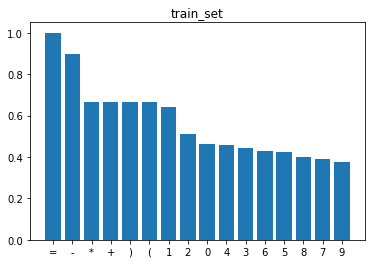

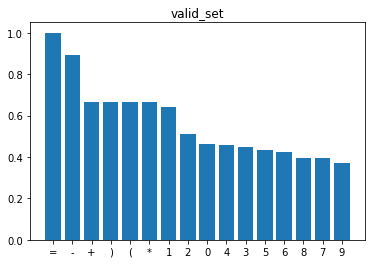

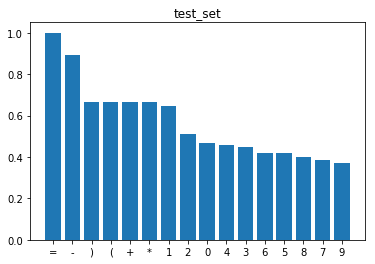

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


D:\ProgramData\envs\tfdl_py35\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("th...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 300, 64, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 300, 64, 32)  2432        the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 300, 64, 32)  128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 300, 64, 32)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Epoch 1/10
 - 1313s - loss: 6.5431 - val_loss: 1.4669
Epoch 2/10
 - 618s - loss: 0.5528 - val_loss: 0.3105
Epoch 3/10
 - 617s - loss: 0.2325 - val_loss: 0.2349
Epoch 4/10
 - 618s - loss: 0.1306 - val_loss: 0.1499
Epoch 5/10
 - 619s - loss: 0.0798 - val_loss: 0.1198
Epoch 6/10
 - 619s - loss: 0.0500 - val_loss: 0.0823
Epoch 7/10
 - 620s - loss: 0.0375 - val_loss: 0.0821
Epoch 8/10
 - 620s - loss: 0.0347 - val_loss: 0.0754
Epoch 9/10
 - 618s - loss: 0.0243 - val_loss: 0.0870
Epoch 10/10
 - 618s - loss: 0.0250 - val_loss: 0.1140


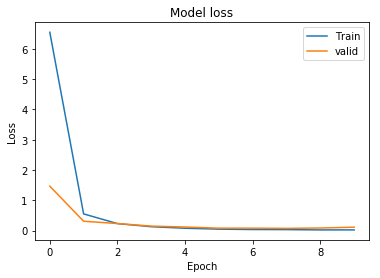

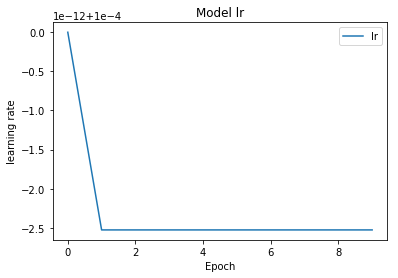

In [10]:
train(train_time, 0, 10, 1e-04)

### 继续训练数据

In [11]:
train_time = '20190305-185535'

D:\ProgramData\envs\tfdl_py35\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("th...)`


Epoch 11/20
 - 622s - loss: 0.0068 - val_loss: 0.0359
Epoch 12/20
 - 616s - loss: 0.0037 - val_loss: 0.0337
Epoch 13/20
 - 617s - loss: 0.0029 - val_loss: 0.0346
Epoch 14/20
 - 616s - loss: 0.0021 - val_loss: 0.0409
Epoch 15/20
 - 616s - loss: 0.0023 - val_loss: 0.0377
Epoch 16/20
 - 616s - loss: 0.0019 - val_loss: 0.0361
Epoch 17/20
 - 617s - loss: 0.0014 - val_loss: 0.0367
Epoch 18/20
 - 616s - loss: 0.0011 - val_loss: 0.0358
Epoch 19/20
 - 616s - loss: 0.0023 - val_loss: 0.0366
Epoch 20/20
 - 616s - loss: 0.0012 - val_loss: 0.0346


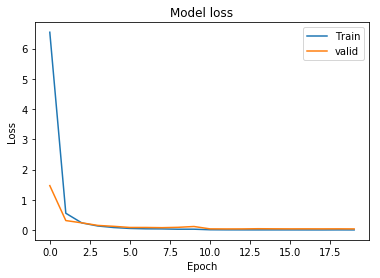

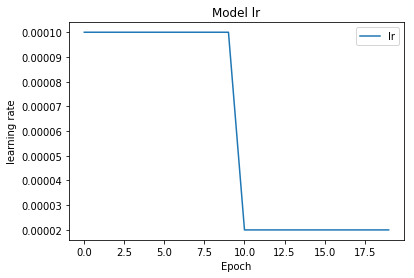

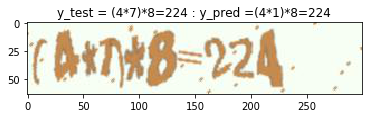

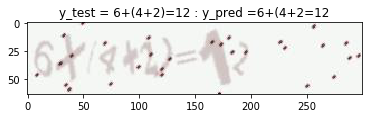

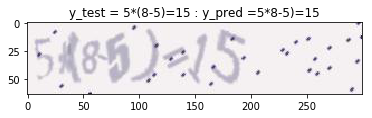

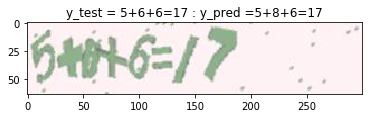

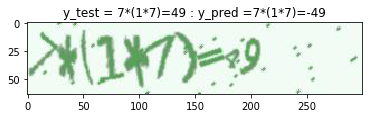

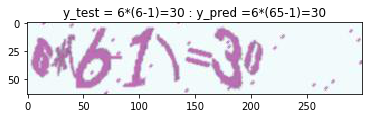

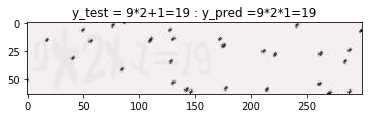

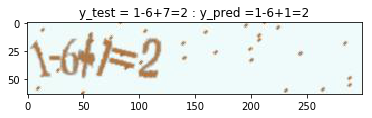

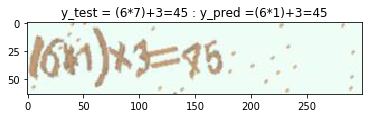

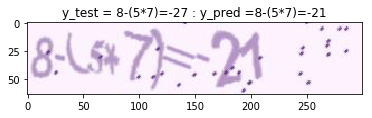

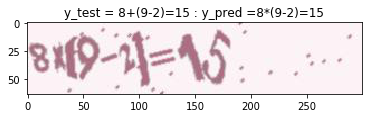

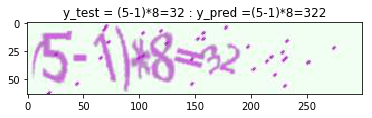

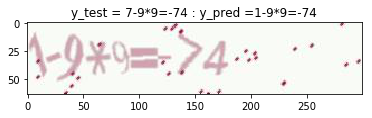

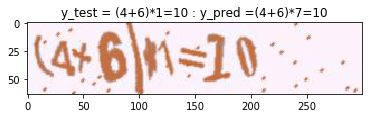

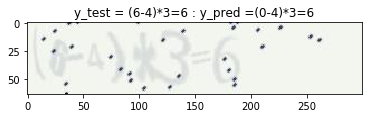

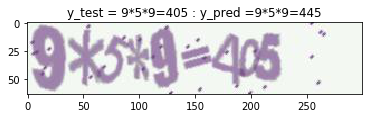

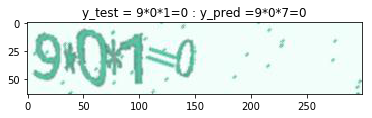

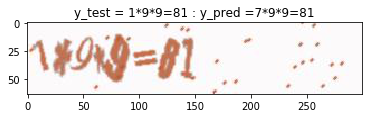

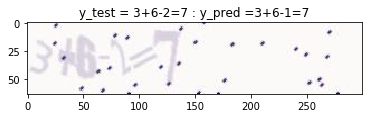

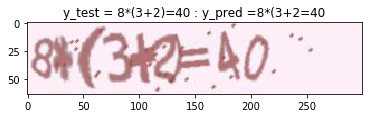

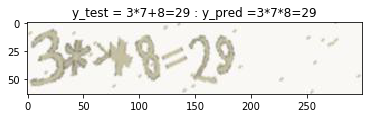

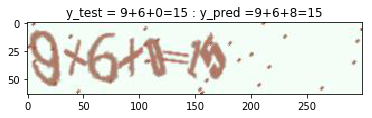

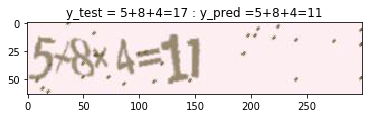

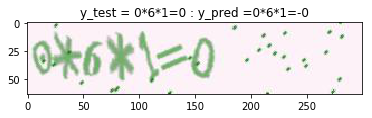

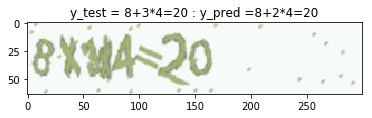

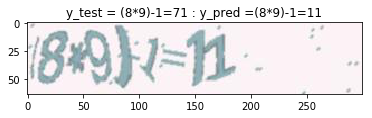

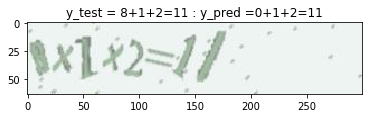

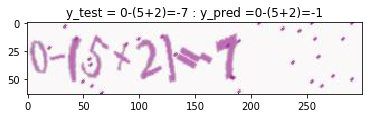

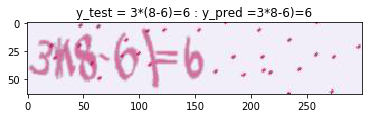

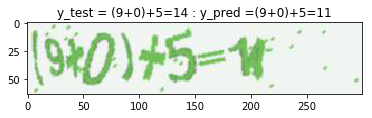

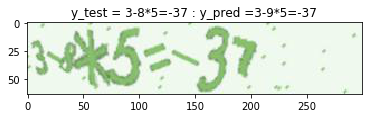

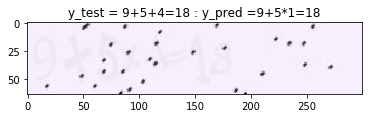

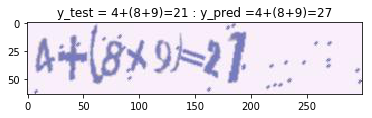

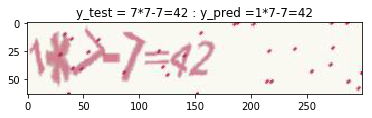

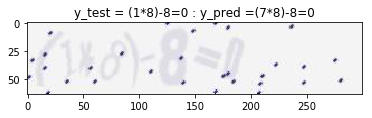

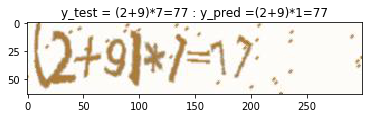

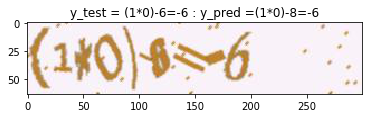

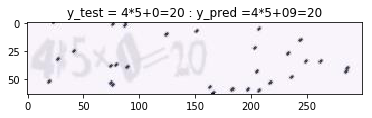

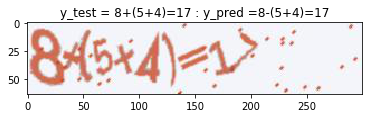

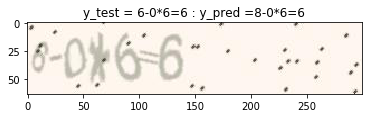

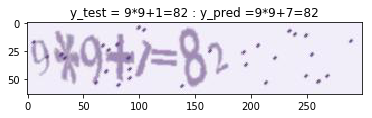

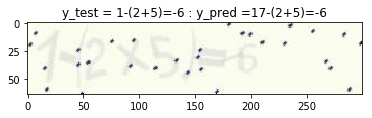

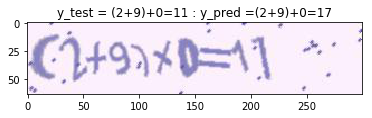

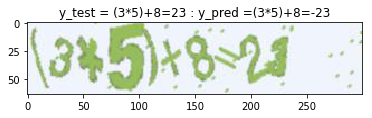

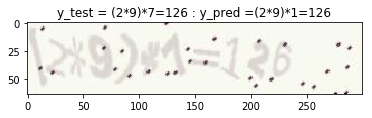

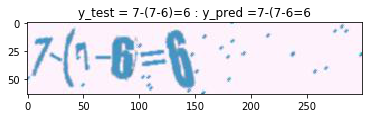

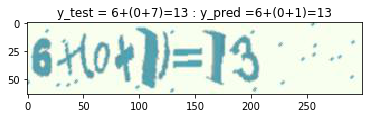

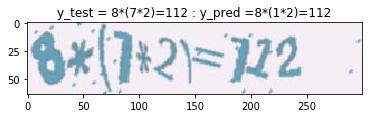

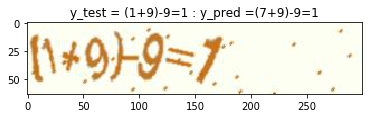

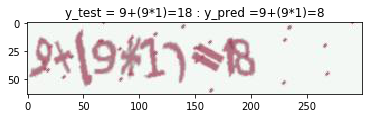

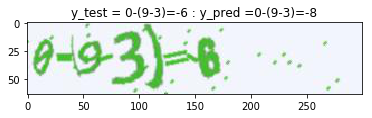

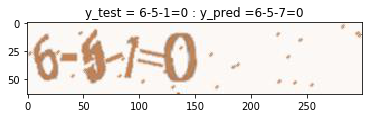

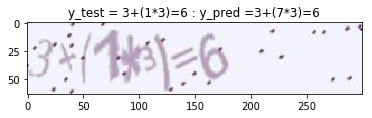

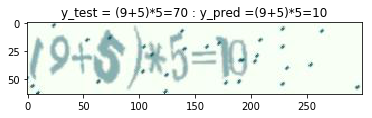

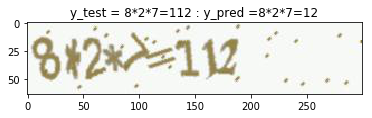

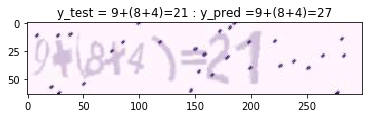

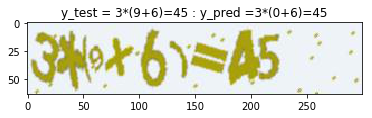

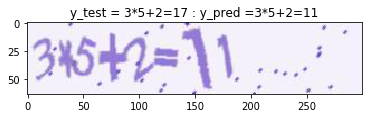

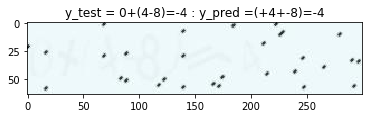

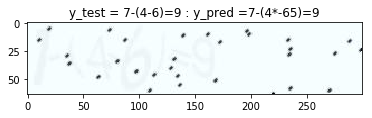

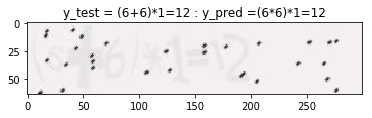

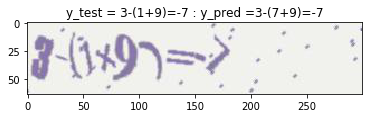

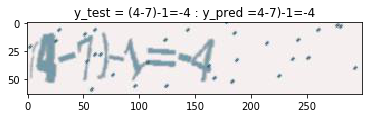

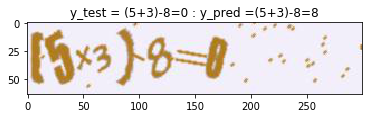

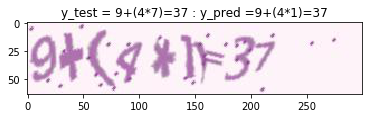

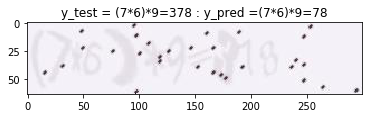

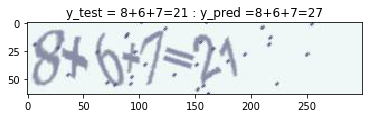

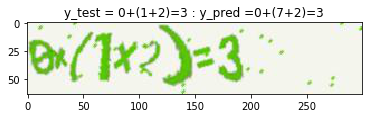

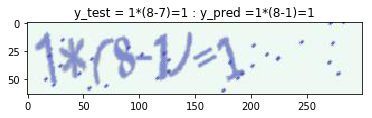

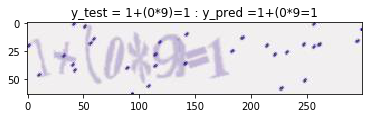

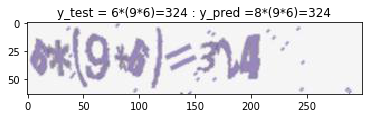

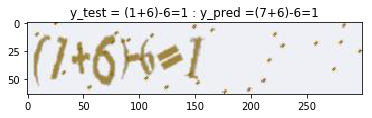

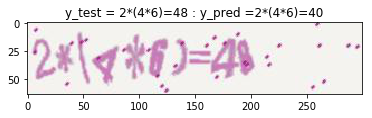

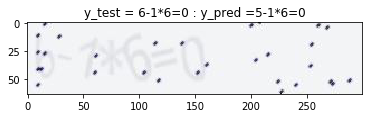

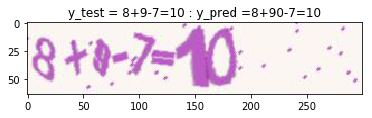

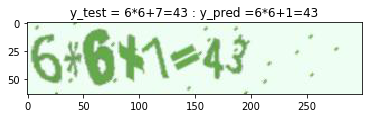

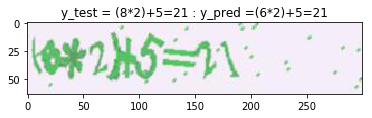

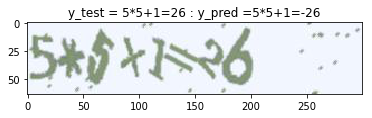

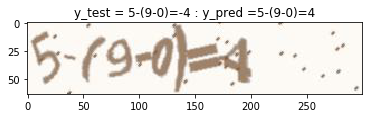

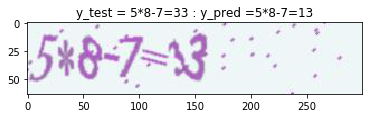

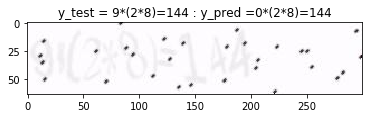

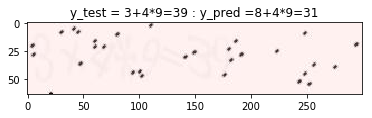

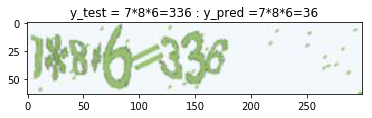

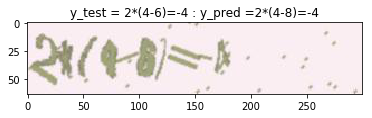

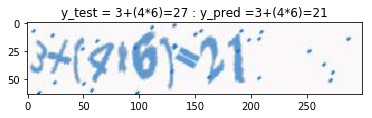

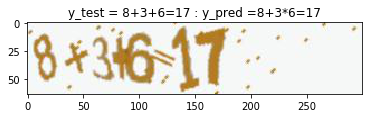

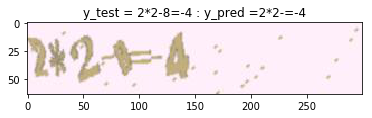

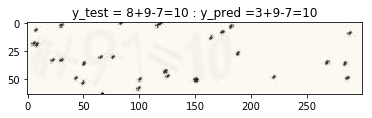

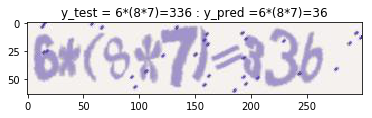

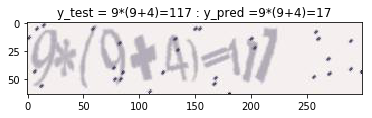

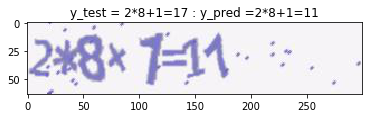

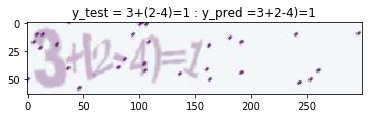

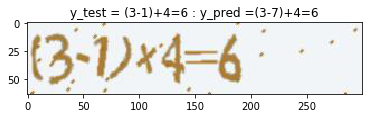

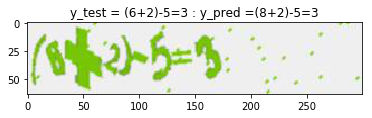

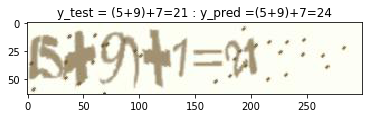

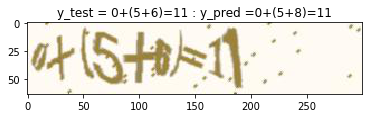

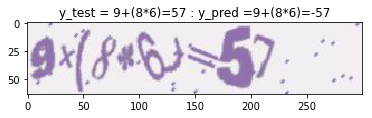

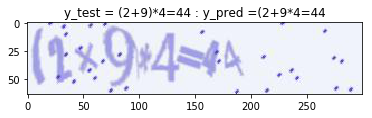

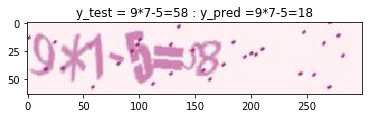

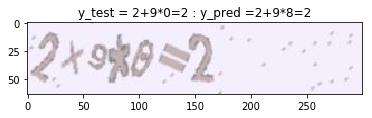

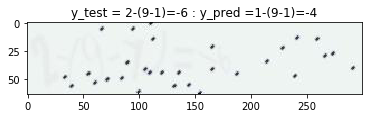

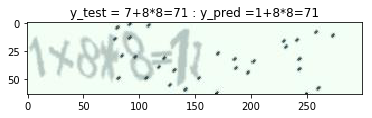

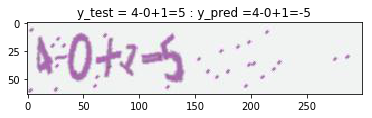

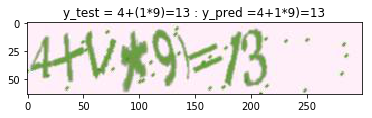

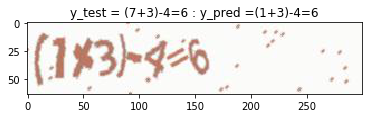

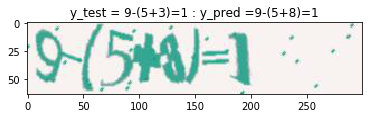

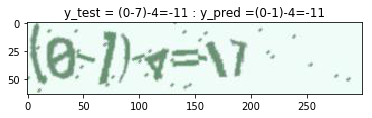

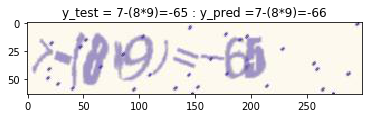

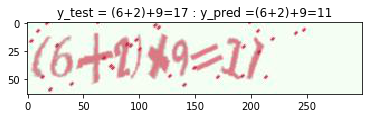

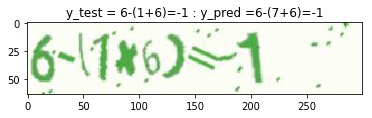

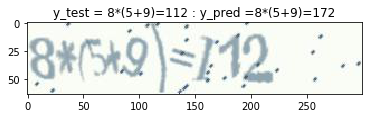

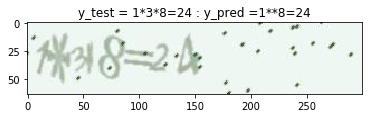

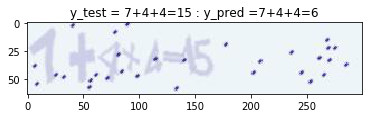

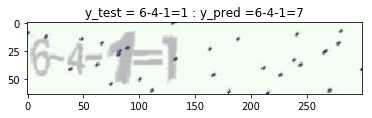

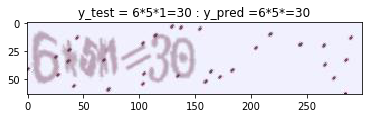

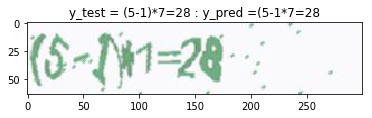

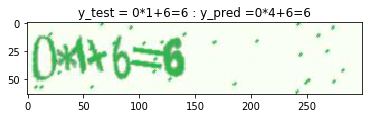

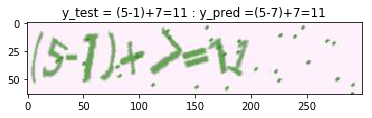

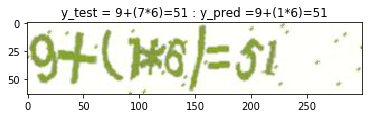

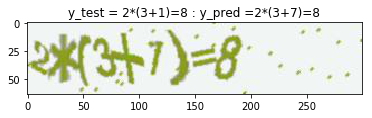

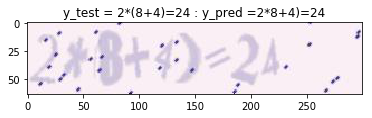

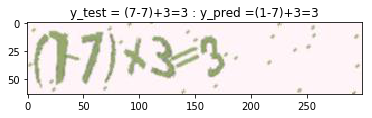

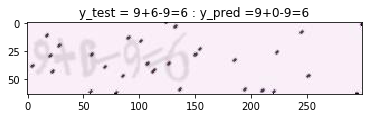

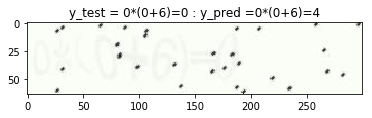

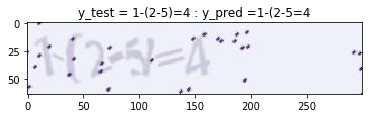

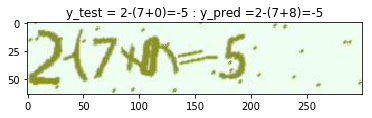

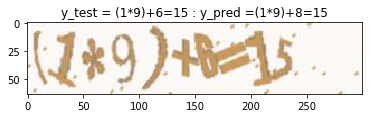

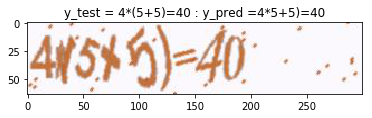

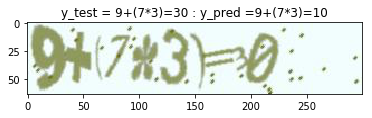

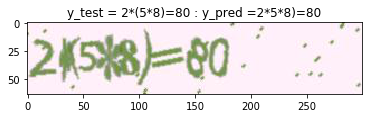

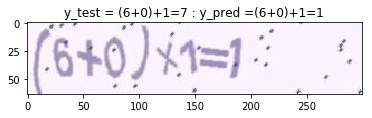

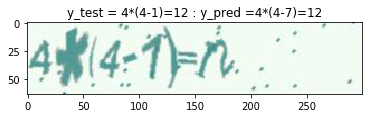

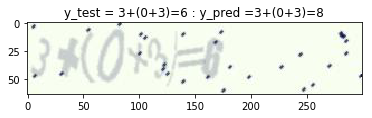

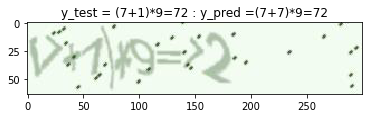

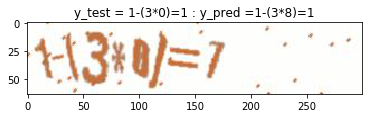

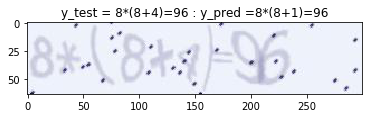

[1.0, 0.99, 0.99, 1.0, 0.99, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 1.0, 0.98, 0.99, 1.0, 0.99, 0.99, 0.99, 1.0, 1.0, 0.99, 1.0, 1.0, 0.96, 0.97, 0.98, 1.0, 1.0, 0.99, 0.99, 0.99, 0.98, 0.99, 1.0, 1.0, 0.98, 0.98, 0.99, 0.98, 1.0, 0.99, 0.99, 0.97, 0.98, 0.99, 0.99, 0.99, 1.0, 1.0, 0.99, 0.99, 1.0, 0.99, 0.99, 0.98, 0.99, 0.99, 0.99, 1.0, 0.98, 0.99, 0.98, 1.0, 0.98, 0.99, 1.0, 0.99, 1.0, 0.98, 0.98, 0.99, 0.99, 0.99, 0.97, 0.98, 0.99, 1.0, 1.0, 1.0, 0.98, 1.0, 0.97, 0.98, 1.0, 0.99, 0.99, 0.98, 0.98, 0.98, 1.0, 1.0, 1.0, 0.99, 0.98, 1.0, 0.99, 0.99, 0.96, 1.0, 0.98, 1.0, 0.99, 1.0, 0.98, 0.99, 0.98, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 0.99, 1.0, 0.99, 0.99, 0.99, 0.98, 1.0, 1.0, 0.99, 0.99, 0.99, 1.0, 0.98, 0.98, 0.99, 0.98, 1.0, 0.99, 1.0, 0.98, 0.99, 0.99, 1.0, 1.0, 0.99, 1.0, 0.99, 0.99, 1.0, 1.0, 1.0, 0.99, 1.0, 0.99, 0.99, 0.98, 0.98, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 0.99, 0.99, 1.0, 1.0, 1.0, 0.98, 0.99, 0.99, 0.99, 0.98, 1.0, 0.99, 0.99, 0.99, 1.0, 0.97, 0.99

In [12]:
train(train_time, 10, 20, 2e-05, test_proc=True)

In [ ]:
# train(train_time, 100, 100, 5e-06, test_proc=True)

**Reference:**

[LSTM/GRU门控机制](https://zhuanlan.zhihu.com/p/28297161)

[Keras官网中文](https://keras.io/zh)

[Keras.callbacks.callback 文档](https://keras.io/zh/callbacks/#callback)

[Keras.callbacks.callback 源码](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L148)

[Keras Image OCR 示例程序](https://github.com/keras-team/keras/blob/master/examples/image_ocr.py)

[train_test_split参考网页](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)